##Cell 1: Importing Libraries


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import random

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

from google.colab import drive
drive.mount('/content/drive')

print("All libraries imported.")

Mounted at /content/drive
All libraries imported.


##Cell 2: Dataset Paths and Configuration

In [ ]:
data_path = '/content/drive/My Drive/Minor1/AutismDataset'
train_path = f"{data_path}/train"
valid_path = f"{data_path}/valid"
test_path = f"{data_path}/test"

IMG_SIZE = 224
BATCH_SIZE = 32

print(f"Training Path: {train_path}")
print(f"Validation Path: {valid_path}")
print(f"Test Path: {test_path}")


Training Path: /content/drive/My Drive/Minor1/AutismDataset/train
Validation Path: /content/drive/My Drive/Minor1/AutismDataset/valid
Test Path: /content/drive/My Drive/Minor1/AutismDataset/test


##Cell 3: Data Preprocessing with Augmentation

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(
    train_path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary'
)

valid_data = valid_datagen.flow_from_directory(
    valid_path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=1, class_mode='binary', shuffle=False
)


Found 2540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


##Cell 4: Building the VGG16 Model with Fine-Tuning

In [ ]:
# Imports
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Define image size and input shape
IMG_SIZE = 224  # Standard input size for VGG16

# Load the VGG16 model with pretrained ImageNet weights, excluding the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all layers except the last 4 to allow fine-tuning
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add an explicit input layer for better shape tracking (optional but useful)
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Build the sequential model
model = Sequential([
    input_layer,           # Explicit input layer
    base_model,             # VGG16 base model
    GlobalAveragePooling2D(),  # Avoid flatten to prevent shape-related issues
    Dense(512, activation='relu'),  # Fully connected layer
    BatchNormalization(),   # Helps with faster convergence and stability
    Dropout(0.5),           # Regularization to reduce overfitting
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
try:
    model.summary()
except ValueError as e:
    print(f"Model summary failed with error: {e}")
    # Debug: Check the output shape of each layer
    for layer in model.layers:
        print(f"{layer.name}: {layer.output_shape}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,979,905 (57.14 MB)

 Trainable params: 7,343,617 (28.01 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

##Cell 5: Compute Class Weights for Balanced Training

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',  # Balances classes automatically
    classes=np.unique(train_data.classes),  # List of class labels
    y=train_data.classes  # Target classes from training data
)

# Convert to dictionary format expected by the model's fit() function
class_weights = dict(enumerate(class_weights))

print("Computed Class Weights:", class_weights)


Computed Class Weights: {0: 1.0, 1: 1.0}


##Cell 6: Training the Model with Early Stopping and Learning Rate Scheduler

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Define EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Define ReduceLROnPlateau for dynamic learning rate adjustment
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Save the best model to your Google Drive folder
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Minor1/VGG16_Autism_best_model.keras',  # Google Drive path
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model with callbacks
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

# Display message after training completes
print("Training completed. Best model saved to 'drive/MyDrive/Minor1/VGG16_Autism_best_model.keras'.")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6574 - loss: 0.6760
Epoch 1: val_loss improved from inf to 0.63142, saving model to /content/drive/MyDrive/Minor1/VGG16_Autism_best_model.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 592s 7s/step - accuracy: 0.6577 - loss: 0.6754 - val_accuracy: 0.7700 - val_loss: 0.6314 - learning_rate: 1.0000e-04
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.7281 - loss: 0.5429
Epoch 2: val_loss improved from 0.63142 to 0.59141, saving model to /content/drive/MyDrive/Minor1/VGG16_Autism_best_model.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 79s 556ms/step - accuracy: 0.7282 - loss: 0.5426 - val_accuracy: 0.7400 - val_loss: 0.5914 - learning_rate: 1.0000e-04
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.7818 - loss: 0.4659
Epoch 3: val_loss improved from 0.59141 to 0.55309, saving model to /content/drive/MyDrive/Minor1/VGG16_Autism_best_model.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 546ms/step - accuracy: 0.7816 - loss: 0.4663 - val_accu

In [ ]:
!ls drive/MyDrive/Minor1
model.summary()

AutismDataset		  finalVGG16_Autism_Classification.ipynb  vgg16_autism_detection01.h5
autismDetection.ipynb	  VGG16_Autism_best_model.keras		  vgg16_autism_detection.keras
autismpresentation.ipynb  VGG16_autism_classification.ipynb


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,979,905 (57.14 MB)

 Trainable params: 7,343,617 (28.01 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

##Cell 8: Model Evaluation and Visualization

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


320/320 ━━━━━━━━━━━━━━━━━━━━ 133s 409ms/step
Classification Report:
              precision    recall  f1-score   support

    Autistic       0.80      0.89      0.84       150
Non-Autistic       0.89      0.80      0.84       170

    accuracy                           0.84       320
   macro avg       0.85      0.85      0.84       320
weighted avg       0.85      0.84      0.84       320



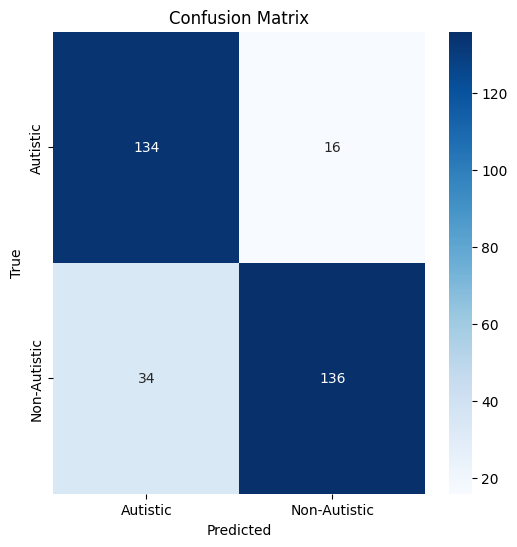

320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


<ipython-input-12-afc9a830b1aa>:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')  # Diagonal line for reference


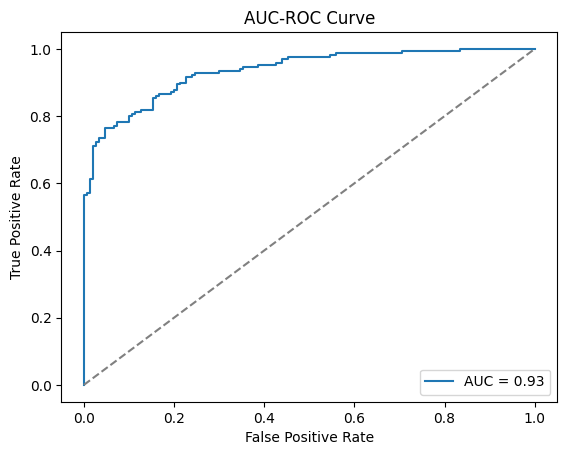

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Generate predictions on the test data
test_data.reset()  # Reset the generator to avoid shuffling issues
y_pred = (model.predict(test_data) > 0.5).astype('int32')  # Apply threshold to probabilities
y_true = test_data.classes  # True labels from the test dataset

# 2. Print the Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Autistic', 'Non-Autistic']))

# 3. Plot the Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Autistic', 'Non-Autistic'],
            yticklabels=['Autistic', 'Non-Autistic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 4. Plot the AUC-ROC Curve
y_pred_prob = model.predict(test_data)  # Predicted probabilities
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', color='gray')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

##Cell 9: Single Image Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


<ipython-input-20-8c8e9a9bc3d1>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(prediction[0] > 0.5)  # Binary threshold at 0.5


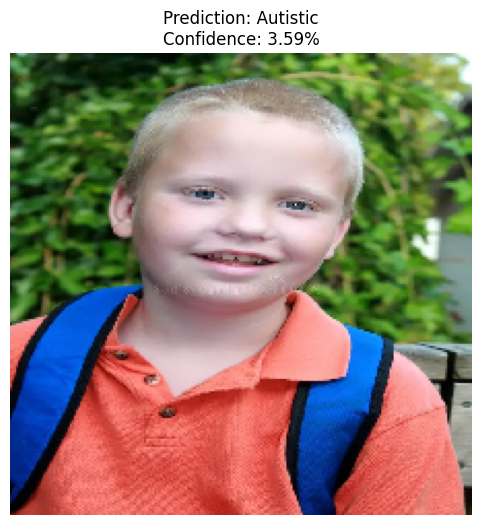

The model predicts: Autistic with confidence: 3.59%


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Define constants for the image input
IMG_SIZE = 224  # Image size for VGG16 input

# 1. Function to preprocess the input image
def preprocess_image(image_path):
    # Load the image and resize to (224, 224)
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

    # Convert the image to a numpy array and scale pixel values to [0, 1]
    img_array = img_to_array(img) / 255.0

    # Expand dimensions to match the model's input shape (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    return img, img_array

# 2. Define the path to the new image
new_image_path = '/content/drive/MyDrive/Minor1/AutismDataset/test/test1.jpg'  # Replace with your image path

# 3. Preprocess the image
image, processed_image = preprocess_image(new_image_path)

# 4. Use the trained model to make a prediction
prediction = model.predict(processed_image)

# 5. Interpret the prediction
class_labels = {0: 'Autistic', 1: 'Non-Autistic'}
predicted_class = int(prediction[0] > 0.5)  # Binary threshold at 0.5
confidence = prediction[0][0] * 100  # Confidence in percentage

# 6. Display the image with the prediction
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')  # Hide axis for better display
plt.title(f"Prediction: {class_labels[predicted_class]}\nConfidence: {confidence:.2f}%")
plt.show()

# 7. Print the prediction result in the console as well
print(f"The model predicts: {class_labels[predicted_class]} "
      f"with confidence: {confidence:.2f}%")
